### Tutorial A: basic set-up

#### (1) Loading in modules

In [4]:
# basic modules
import networkx as nx
import numpy as np
import sys
import matplotlib.pyplot as plt

In [5]:
# TAO-related modules
sys.path.append('/Users/user/Documents/work/RL-outbreak/tao') # add path to modules
from binary_prevalence.active_allocation import ActivePolicy
from binary_prevalence.passive_allocation import PassivePolicy
from binary_prevalence.surrogate.static_car import StaticCAR
from binary_prevalence.agent import BaseAgent
from binary_prevalence.evaluation import BaseEvaluator
from binary_prevalence.environment import BinaryPrevalenceEnvironment
from tao_manager import TaoManager

#### (2) Creating a test-graph (for setting up the environment)

Let's generate several graphs with different degrees of community structure

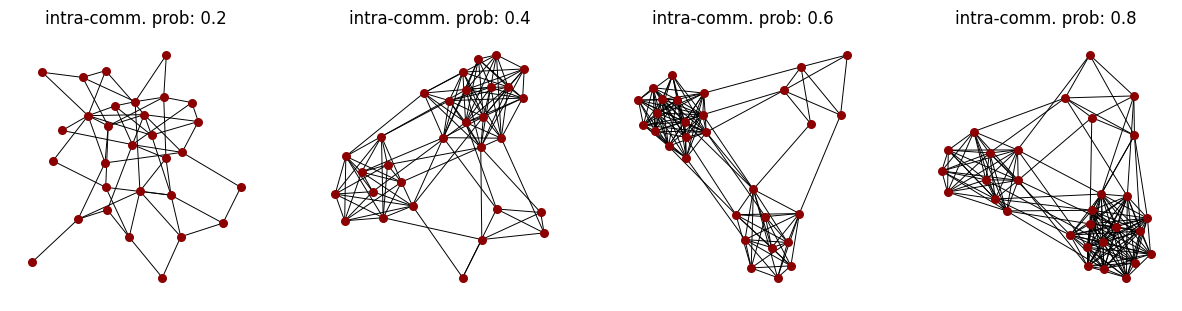

In [24]:
from utils.helper_functions import generate_random_graph_with_communities

# params
community_sizes = [5, 10, 15]
intra_community_probs = [0.2, 0.4, 0.6, 0.8] # high, medium, low community structure
inter_community_prob = 0.06 # fix inter-community connection probability

# generate and plot graphs
plt.figure(figsize=(15, 3.5))
graphs_store = {}
for i, intra_prob in enumerate(intra_community_probs, 1):
    G = generate_random_graph_with_communities(community_sizes, intra_prob, inter_community_prob)
    graphs_store[intra_prob] = G
    plt.subplot(1, len(intra_community_probs), i)
    nx.draw(G, node_size=30, node_color='darkred', width=0.7, with_labels=False)
    plt.title(f'intra-comm. prob: {intra_prob}')

plt.show()

We will pick the graph generated with intra_community_prob = 0.4

In [25]:
# select graph with intra_community_prob=0.4
selected_graph = graphs_store[0.4]

For bookkeeping, we will export the graph as an adjlist file

In [5]:
from utils.helper_functions import save_graph
save_graph(selected_graph, './', 'test-graph.adjlist')

#### (3) Initialise the environment with selected graph
Alternatively, we could initialise an empty environment and set up the graph later

In [35]:
# initialise (binary prevalence) environment using selected graph
env = BinaryPrevalenceEnvironment(selected_graph)

##### Next we need to give the environment history of infection states
i.e. absence/presence of the pathogen at all the nodes at different times. There are a few ways to do this. We will demonstrate three different approaches below, with the last being concerning static prevalence in particular:

(3.1) Simulate (simple) transmission process over graph

In [36]:
# we will run the simulation for 10 units of time
end_time = 10
# number of index cases (initially infected nodes)
num_index_cases = 1
# transmission prob.
transmission_prob = 0.05

# simulate simple transmission process
env.initialise_simulated_infection_states(end_time, initial_infected_num=num_index_cases,
                                          transmission_p=transmission_prob, static=False)

Let's print them out and take a look

In [37]:
# print infection states history
for time, infection_states in env.infections_history.items():
    print(f't={time}, infection_states: {infection_states}')

t=0, infection_states: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
t=1, infection_states: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
t=2, infection_states: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
t=3, infection_states: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
t=4, infection_states: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
t=5, infection_states: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]
t=6, infection_states: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
t=7, infection_states: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
t=8, infection_states: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1

We can also animate the dissemination process for visual inspection (\***IMPORTANT\*** if the plot doesn't show up the first time, please try again by interrupting the process and rerunning the cell; it is not clear what is causing this issue at the moment)

pos_seed provided: 0


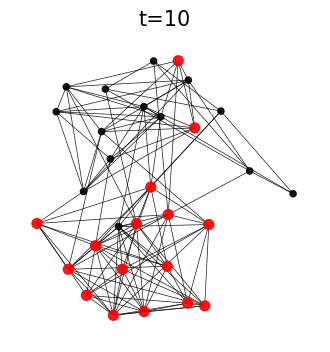

In [49]:
from utils.binary_prevalence_plot import animate_observations_history
animate_observations_history(env, plot_dim=(4, 4), pos_seed=0, fps=1.5,
                             infected_node_size=50, uninfected_node_size=20,
                             uninfected_node_color='black')

For bookkeeping, we will export the simulated infection states as a csv file

In [10]:
# export infection history
env.export_infections_history('./', 'simulated-infection-history.csv')

(3.2) Reading in simulated infection states from file (suppose we have already generated a set of simulated infection states)

In [11]:
# read simulated infection states history from file
env.set_infection_states_from_file('./simulated-infection-history.csv', header=True)

(3.3) Setting static prevalence from simulated transmission process; here we simulate a (simple) transmission process over the graph up to some time T, and take the final infection states as the static prevalence; this is equivalent to setting query rate >> 1, such that the rate at which new observations are made is much higher than the rate at which prevalence is updated

In [12]:
# we will run the simulation for 10 units of time
end_time = 10
# number of index cases (initially infected nodes)
num_index_cases = 1
# transmission prob.
transmission_prob = 0.05

# simulate simple transmission process (like 3.1), except that we set static=True
# here we set the up_time to end_time, alternatively we could have set it to any positive integer
# (running this line is probably going to throw an error since the infection states are already set)
env.initialise_simulated_infection_states(end_time, up_time=end_time, initial_infected_num=num_index_cases,
                                          transmission_p=transmission_prob, static=True)

Exception: infections_history is not None, initialisation aborted

#### (4) Initialise a model agent
which we will then make multiple copies of. However, before we can do that, we must first collect all the necessary "materials": 
- the same graph as in the environment where the TAO-simulation is going to be run (which we already have)
- (4.1) a passive allocation-policy, by which nodes are selected for observations prior to the first iteration of active learning
- (4.2) an active allocation-policy (active learning loop)
- (4.3) a surrogate model with which prevalence estimates are made

(4.1) Initialise a passive allocation-policy

Let's see what policies are available

In [13]:
# show available passive allocation-policies (refer to README.md for more details)
for policy in PassivePolicy.DEFAULT_PASSIVE_POLICIES.keys():
    print(policy)

random
degree_central
betweenness_central
closeness_central
eigenvector_central


We will go with "degree_central" for now (i.e. the most central n nodes (by degree centrality) are selected for observation during passive-allocation); we will also set num_batch to 2, i.e. two nodes are observed

In [14]:
# initialise and set it to degree_central
passive_policy = PassivePolicy('degree_central')
passive_policy.num_batch = 2

(4.2) Initialise an active allocation-policy

In [15]:
# show available active allocation-policies (refer to README.md for more details)
for policy in ActivePolicy.DEFAULT_ALLOCATION_POLICIES.keys():
    print(policy)

random
reactive
reactive_infected
reactive_uninfected
least_confidence
node_entropy
bald


We will go with "reactive_infected" for now (i.e. neighbours of nodes that are recently observed to be infected are selected where available, otherwise unobserved nodes are randomly selected); we will also set num_batch to 1 (default), i.e. a single node is selected per round of observation

In [16]:
# initialise and set it to reactive_infected
active_policy = ActivePolicy('reactive_infected')
active_policy.num_batch = 1

(4.3) Add a surrogate model; there are two approaches:
- (4.3.1) initialise a surrogate model and add it to the agent (see later)
- (4.3.2) add a surrogate model to the agent directly using built-in method; unlike the first approach, this ensures that the surrogate has access to the same graph as the agent without having to do it manually

We will show both approaches below

(4.3.1) Initialise a surrogate model

In [17]:
# initialise a surrogate model
surrogate = StaticCAR(env.graph)

# adjust MCMC params
surrogate.configs['mcmc_params'] = {
    'num_warmup': 1000,
    'num_samples': 2500,
    'num_chains': 2
}

# alternatively, we can set the params from a yaml file
surrogate.parse_configs_yaml('./mcmc-params.yaml')

Now that we have all the materials, we can finally initialise an agent as follows

In [18]:
# initialise an agent with surrogate
model_agent = BaseAgent(env.graph, passive_policy, active_policy, surrogate=surrogate)

# let's see what we have created
model_agent.__dict__

{'_id': UUID('375b3336-3fc2-42ed-b2e8-b209e2ad0fae'),
 'env_graph': <networkx.classes.graph.Graph at 0x154440c10>,
 'surrogate': <binary_prevalence.surrogate.static_car.StaticCAR at 0x1545c92e0>,
 'passive_allocation_policy': <binary_prevalence.passive_allocation.base.PassivePolicy at 0x1545c9310>,
 'allocation_policy': <binary_prevalence.active_allocation.base.ActivePolicy at 0x1545c9190>,
 'allocation_start_time': 0,
 'query_rate': 1,
 '_is_run': False}

Note that allocation_start_time is set to 0 by default, i.e. time when the selected passive allocation-policy is deployed, followed immediately by the deployment of the selected active allocation-policy; query_rate is set to 1 by default

(4.3.2) Unlike (4.3.1), here we initialise an agent without providing a surrogate, and only add a surrogate once the agent has been initialised

In [19]:
# initialise an agent without surrogate
model_agent = BaseAgent(env.graph, passive_policy, active_policy)

# now add surrogate
model_agent.add_surrogate(model='car')

# we will need to set the configs for the surrogate as before
model_agent.surrogate.parse_configs_yaml('./mcmc-params.yaml')

The agent's run-state (whether it has already gone through a TAO-run) is stored in the _is_run attribute, which can be access via

In [20]:
# get agent's run-state
model_agent.is_run

False

Say if we want to change the number of nodes to observe during passive-allocation to 4, we can do the following

In [21]:
# change num_batch in passive_policy to 4
model_agent.passive_allocation_policy.num_batch = 4

#### (5) Create multiple copies of the same model-agent
As noted in README.md, due to inherent stochasticity in the prevalence estimates from the surrogate model and in the allocation-policies, each agent represents a random realisation of a disease surveillance process. It is therefore important that we consider a sufficiently large number of the same (copies of) the agent in order to examine the full distribution of its behaviours/characteristics.

We can create multiple copies of the same agent with the same (both passive and active) allocation-policies and surrogate model as follows

In [22]:
# create 4 copies of model_agent
num_copies = 4
model_agent_copies = model_agent.spawn_empty_copies(num_copies)

# print agents' ids
for agent in model_agent_copies:
    print(agent.id)

18f5bbe2-eb0f-42
8b4c05c7-f31d-48
73d1965d-01e5-49
96a0cfcd-769f-45


Note that each agent is given a different id and therefore a different random generator seed; note also that any changes in model_agent will not be reflected in any of these copies

#### (6) Repeat step 4 to 6, but with a different active allocation-policy (otherwise the same)

(passive-allocation) we can just reuse what has been initialised before

(active-allocation) we will initialise a new active allocation-policy and set it to least_confidence

In [23]:
# initialise an active allocation-policy and set it to least_confidence
active_least_conf_policy = ActivePolicy('least_confidence')
# use the same num_batch
active_least_conf_policy.num_batch = 1

(surrogate) we will reuse the surrogate model

(model-agent) we will create a new model-agent with the new active allocation-policy

In [24]:
# initialise an agent without surrogate
least_conf_model_agent = BaseAgent(env.graph, passive_policy, active_least_conf_policy)

# now add surrogate
least_conf_model_agent.add_surrogate(model='car')

# set params from a yaml file
least_conf_model_agent.surrogate.parse_configs_yaml('./mcmc-params.yaml')

(spawn multiple copies) finally, we will create multiple copies of the new model-agent

In [25]:
# create 4 copies of least_conf_model_agent
num_copies = 4
least_conf_model_agent_copies = least_conf_model_agent.spawn_empty_copies(num_copies)

# print agents' ids
for agent in least_conf_model_agent_copies:
    print(agent.id)

1caea4b0-00b0-42
0a96b066-fa4d-4e
66eed46e-b689-4b
e7daee22-310a-46


#### (7) Put everything into a TaoManager
TaoManager helps manage the communication between each agent and the environment, ensuring that all agents have access to the same information (infection states); this is also where the TAO-runs will be performed and the output stored

In [26]:
# initialise a TaoManager by providing at least an environment
tao = TaoManager(env)

# let's see what's inside
tao.__dict__

{'name': 'faithful_axolotl',
 'env': <binary_prevalence.environment.BinaryPrevalenceEnvironment at 0x154709e50>,
 'agents': array([], dtype=float64),
 'evaluator': None,
 'configs': None}

Note that a random name is generated for the TaoManager for ease of identification; we still need to add the agents that we have created in the previous step, so let's do that

In [27]:
# add model_agent_copies to tao
tao.add_agents(model_agent_copies)
# add least_conf_model_agent_copies to tao
tao.add_agents(least_conf_model_agent_copies)

We will deal with the evaluator later; the configs attribute is where any parameters associated with the TAO-run are stored; as an example here, we will show two different approaches to changing the maximum number of CPU cores to use for updating the surrogate model

In [28]:
# adjust MCMC params
tao.configs = { 'max_num_core': 5 }

# alternatively, we can set the params from a yaml file
tao.parse_configs_yaml('./tao-params.yaml')

#### (8) Finally, we are ready to perform our first TAO-run
There are three arguments that we need to worry about when performing a TOA-run:
- [**agent_ids**]: a list of ids of agents that we want to run; if None is provided (by default), all agents in the TaoManager are run
- [**up_to_time**]: the number of time-steps to run; by default, each agent is run up to either the up_time of the environment (the maximum time for which infection states are available), or when there are no remaining unobserved nodes in the surrogate (when this happens depends on the allocation-policies specified)
- [**time_increment**]: this variable is external to both the environment and the agents; the reason that this variable exists is to allow for different query rates (i.e. how frequently new observations are made/the surrogate is updated, relative to the rate at which infection states/prevalence is updated); for example, if we are to set the query rate of a given allocation-policy to 3, this means that for each time-step in the environment, the surrogate is updated 3 times with new observations; in order to accommodate non-integer update times, we would have to set time_increment to ideally a small value (like 0.0001); this is set to 0.1 by default

In this example, we are going to run all 5 agents up to t=10 (as specified before), with time increment of 1 (since we have set the query rate to 1 previously for all agents)

In [29]:
# run tao (with parallelisation)
tao.run(time_increment=1)

Starting TAO-run for faithful_axolotl, up to 10 steps at 1.000000 increment...
Allocation-policy summary:
  -> number of agents: 8
  -> (passive) allocation policies:
        [1] degree_central: 8
  -> (active) allocation policies:
        [1] reactive_infected: 4
        [2] least_confidence: 4
Number of cores to use: 5


[18f5bbe2-eb0f-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[8b4c05c7-f31d-48]:   0%|          | 0/10 [00:00<?, ?it/s]



[73d1965d-01e5-49]:   0%|          | 0/10 [00:00<?, ?it/s]



[96a0cfcd-769f-45]:   0%|          | 0/10 [00:00<?, ?it/s]

[1caea4b0-00b0-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[0a96b066-fa4d-4e]:   0%|          | 0/10 [00:00<?, ?it/s]



[66eed46e-b689-4b]:   0%|          | 0/10 [00:00<?, ?it/s]



[e7daee22-310a-46]:   0%|          | 0/10 [00:00<?, ?it/s]


TAO-run completed.


#### (9) Let's look at some results!
Before we actually look the performance of the allocation-policies, let's have a look if the TAO-run has actually worked; one way to do this is to visualisation the observations that have been made by the different agents

Let's look the first agent (\***IMPORTANT\*** if the plot doesn't show up the first time, please try again by interrupting the process and rerunning the cell; it is not clear what is causing this issue at the moment)

pos_seed provided: 30107


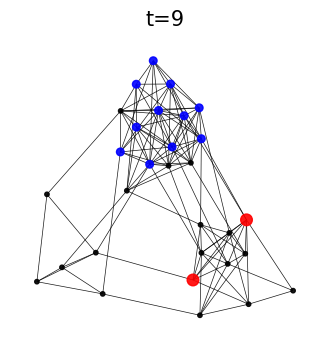

In [30]:
from utils.binary_prevalence_plot import animate_observations_history
animate_observations_history(tao.env, agent=tao.agents[0], plot_dim=(4, 4), fps=1.5, pos_seed=30107,
                             spring_k=0.05, uninfected_node_size=30, unobserved_node_size=10)

Let's look at the second agent

pos_seed provided: 30107


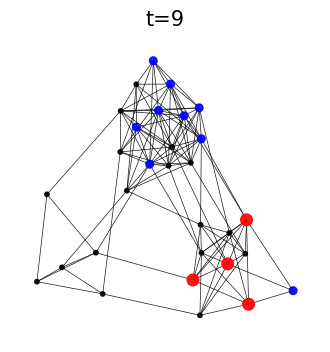

In [34]:
# we will keep the same seed for generating the node positions
animate_observations_history(tao.env, agent=tao.agents[1], plot_dim=(4, 4), pos_seed=30107, fps=1.5,
                             spring_k=0.05, uninfected_node_size=30, unobserved_node_size=10)

#### \**** IMPORTANT \****
In the animations above, black nodes represent locations that still unobserved, red and blue nodes represent locations that have been observed to be infected and uninfected, respectively; note that, since the (prevalence) infection states are time-varying, the observed infection states (as represented by the coloured nodes) do not represent the true underlying prevalence, but the prevalence at the times of observations; this is likely something we will have to give more thoughts to when considerating what the appropriate allocation policy should be when dealing with time-varying prevalence

#### (10) How did the agents perform?
Now that we know that the TAO-run has worked (more or less), let's see how the allocation-policies performed; to do so, we need to specify an appropriate evaluator to calculate a chosen metric of performance

Initialise an evaluator; currently only AUC and PR-AUC are available as performance metrics

In [35]:
# let's see what metrics are available
print(list(BaseEvaluator.DEFAULT_PERFORMANCE_METRICS.keys()))

['auc', 'pr_auc']


In [36]:
# initialise an evaluator, with AUC as designated metric
evaluator = BaseEvaluator('auc')
# add evaluator to TaoManager
tao.evaluator = evaluator

Compute performance metric

In [37]:
# performance metrics are computed for all agents by default
# to compute performance metrics for specific agents, we can provide a list of agent ids
agents_auc = tao.evaluate_performance(as_dataframe=True)

In [38]:
# let's have a look at the results
agents_auc.head(10)

,agent_id,passive_policy,passive_num_batch,active_policy,active_num_batch,active_start_time,query_time,time,num_unobserved_nodes,performance
0,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,0,26,0.625000
1,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,1,25,0.833333
2,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,2,24,0.603175
3,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,3,23,0.866667
4,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,4,22,0.625000
5,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,5,21,0.666667
6,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,6,20,0.750000
7,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,7,19,0.615385
8,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,8,18,0.802469
9,18f5bbe2-eb0f-42,degree_central,4,reactive_infected,1,0,1,9,17,0.513889


Let's plot the performance metrics by active allocation-policy (we should probably not read into these results too much given the size of the graph and the small number of agent replicates per allocation-policy)

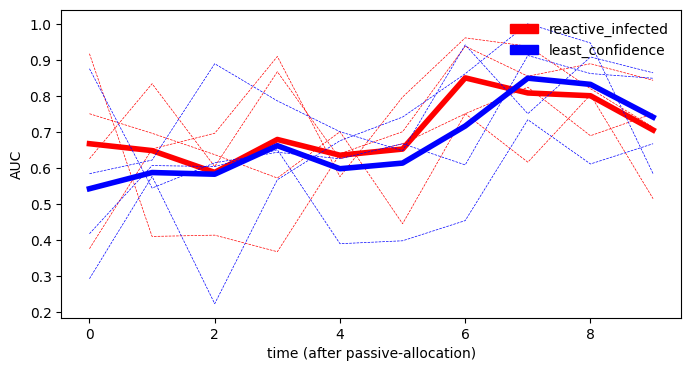

In [39]:
# set up figure
fig, ax = plt.subplots(figsize=(8, 4))

# plot AUC for agents with reactive_infected as active-policy
for agent in agents_auc[agents_auc.active_policy == 'reactive_infected'].agent_id.unique():
    df = agents_auc[agents_auc.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='r')
# compute average AUC per time
reactive_infected_avg_auc = agents_auc[agents_auc.active_policy == 'reactive_infected'].groupby('time').performance.mean()
# plot average AUC
ax.plot(reactive_infected_avg_auc.index, reactive_infected_avg_auc, linestyle='-', linewidth=4, color='r')

# plot AUC for agents with least_confidence as active-policy
for agent in agents_auc[agents_auc.active_policy == 'least_confidence'].agent_id.unique():
    df = agents_auc[agents_auc.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='b')
# compute average AUC per time
least_conf_avg_auc = agents_auc[agents_auc.active_policy == 'least_confidence'].groupby('time').performance.mean()
# plot average AUC
ax.plot(least_conf_avg_auc.index, least_conf_avg_auc, linestyle='-', linewidth=4, color='b')

# add axis labels
ax.set_xlabel('time (after passive-allocation)')
ax.set_ylabel('AUC')

# add legend (adjust custom colours)
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='reactive_infected')
blue_patch = mpatches.Patch(color='blue', label='least_confidence')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', frameon=False)

plt.show()

#### (11) What if we want to select specific nodes during passive-allocation?
Say, we have information of where the first local outbreak happened; here we show how to add a custom passive allocation-policy that select the index node (num_batch=1)


In [40]:
# find index node
index_node = np.where(np.array(env.infections_history[0]) == 1)[0][0]
print(index_node)

10


Define custom passive-policy

Note that the environment cannot be accessed from within the policy function - this is a design choice as the agent should not have access to any information of the underlying prevalence (infection states) prior to the deployment of active-allocation; how testing resources should be allocated during undetected transmission is in nature part of the design of a disease surveillance programme

But for the purpose of demonstration, we will show here how to ensure that the agent always samples the index node during passive-allocation

In [41]:
def select_index_node(**kwargs):
    """
    Selects index node.
    Available kwargs:
        - env_graph: graph of environment (a networkx undirected graph object)
        - num_batch: number of nodes to be selected (int)
        - rng: random number generator for drawing from probability distributions (numpy.random.RandomState)
    """
    # get env_graph and num_batch
    # env_graph = kwargs['env_graph'] # not used in this example
    # num_batch = kwargs['num_batch'] # not used in this example
    # rng = kwargs['rng'] # not used in this example

    # select index node
    return np.array([<insert index node>])

Having defined our own passive allocation-policy, let's add it to the passive_policy object

In [42]:
# add custom passive-policy
passive_policy.add_custom_policy('index_node', select_index_node)

# it doesn't really matter here, but for bookkeeping, we should set num_batch to 1
passive_policy.num_batch = 1

# note that, by default, the passive-policy is set to the newly added custom policy
passive_policy.__dict__

{'policy': 'index_node',
 'num_batch': 1,
 'custom_policies': {'index_node': <function __main__.select_index_node(**kwargs)>}}

We will swap in this new passive_policy object into the agents and reset them

In [43]:
# reset all agents
tao.reset_agents()

# swap in new passive-policy
for agent_i in range(len(tao.agents)):
    tao.agents[agent_i].passive_allocation_policy = passive_policy

Now rerun all agents

In [44]:
# run tao (with parallelisation)
tao.run(time_increment=1)



[8b4c05c7-f31d-48]:   0%|          | 0/10 [00:00<?, ?it/s]

[18f5bbe2-eb0f-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[73d1965d-01e5-49]:   0%|          | 0/10 [00:00<?, ?it/s]

Starting TAO-run for faithful_axolotl, up to 10 steps at 1.000000 increment...
Allocation-policy summary:
  -> number of agents: 8
  -> (passive) allocation policies:
        [1] index_node: 8
  -> (active) allocation policies:
        [1] reactive_infected: 4
        [2] least_confidence: 4
Number of cores to use: 5

TAO-run completed.


[96a0cfcd-769f-45]:   0%|          | 0/10 [00:00<?, ?it/s]

[1caea4b0-00b0-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[0a96b066-fa4d-4e]:   0%|          | 0/10 [00:00<?, ?it/s]



[66eed46e-b689-4b]:   0%|          | 0/10 [00:00<?, ?it/s]



[e7daee22-310a-46]:   0%|          | 0/10 [00:00<?, ?it/s]

Let's animate the observations made by one of the agents as before

pos_seed provided: 30107


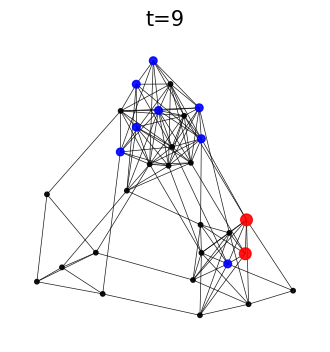

In [45]:
animate_observations_history(tao.env, agent=tao.agents[1], plot_dim=(4, 4), fps=1.5, pos_seed=30107,
                             spring_k=0.05, uninfected_node_size=30, unobserved_node_size=10)

#### (12) How to add your own active allocation-policy?
As an example, we will design a new allocation-policy that selects the num_batch nodes for which we have the highest confidence in their infection states, based on estimates from the surrogate (CAR) model

In [46]:
def most_confidence_select(**kwargs):
    """
    Selects n unobserved nodes with least uncertain infection_estimates, i.e. estimate of latent probability p of infection states closest to 0 or 1.
    Available kwargs:
        - env_graph: graph of environment (a networkx undirected graph object)
        - surrogate: surrogate model specified in agent
        - num_batch: number of nodes to be selected (int)
        - rng: random number generator for drawing from probability distributions (numpy.random.RandomState)
    """
    import jax.numpy as jnp
    import heapq

    # get env_graph, surrogate and num_batch (not needed in this case)
    # env_graph = kwargs['env_graph'] # not used in this example
    surrogate = kwargs['surrogate']
    num_batch = kwargs['num_batch']
    # rng = kwargs['rng'] # not used in this example

    # get observed_infection_states, infection_estimates from surrgate and num_batch
    observed_infection_states = surrogate.get_observed_infection_states()
    infection_estimates = surrogate.get_infection_estimates()

    # extract posterior means from mcmc object
    p_samples = infection_estimates.get_samples()['p']
    p_means = jnp.mean(p_samples, axis=0)

    # calculate min(distance from 0, distance from 1) for each unobserved node
    unobserved_infection_estimate_distances = [(min(abs(p_means[node] - 0), abs(p_means[node] - 1)), node)
                                               for node, infection_state in enumerate(observed_infection_states) if infection_state == -1]
    # use nsmallest to get n nodes with smallest distance from 0 or 1
    selected_nodes = heapq.nsmallest(num_batch, unobserved_infection_estimate_distances)

    return [node for _, node in selected_nodes]

Having defined our own active allocation-policy, let's add it to the active-policy object

In [47]:
# add custom active-policy
active_policy.add_custom_policy('most_confidence', most_confidence_select)

# note that, by default, the active-policy is set to the newly added custom policy
active_policy.__dict__

{'policy': 'most_confidence',
 'num_batch': 1,
 'custom_policies': {'most_confidence': <function __main__.most_confidence_select(**kwargs)>}}

As before, we will swap in this new active_policy object into the agents and reset them

In [48]:
# reset all agents
tao.reset_agents()

# swap in new active-policy for the last 4 agents
for agent_i in range(len(tao.agents) - 4, len(tao.agents)):
    tao.agents[agent_i].allocation_policy = active_policy

Now rerun all agents

In [49]:
# run tao (with parallelisation)
tao.run(time_increment=1)



Starting TAO-run for faithful_axolotl, up to 10 steps at 1.000000 increment...
Allocation-policy summary:
  -> number of agents: 8
  -> (passive) allocation policies:
        [1] index_node: 8
  -> (active) allocation policies:
        [1] most_confidence: 4
        [2] reactive_infected: 4
Number of cores to use: 5

TAO-run completed.


[96a0cfcd-769f-45]:   0%|          | 0/10 [00:00<?, ?it/s]

[73d1965d-01e5-49]:   0%|          | 0/10 [00:00<?, ?it/s]

[1caea4b0-00b0-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[8b4c05c7-f31d-48]:   0%|          | 0/10 [00:00<?, ?it/s]

[18f5bbe2-eb0f-42]:   0%|          | 0/10 [00:00<?, ?it/s]



[0a96b066-fa4d-4e]:   0%|          | 0/10 [00:00<?, ?it/s]



[66eed46e-b689-4b]:   0%|          | 0/10 [00:00<?, ?it/s]



[e7daee22-310a-46]:   0%|          | 0/10 [00:00<?, ?it/s]

Let's animate the observations made by one of the agents as before, one last time

pos_seed provided: 30107


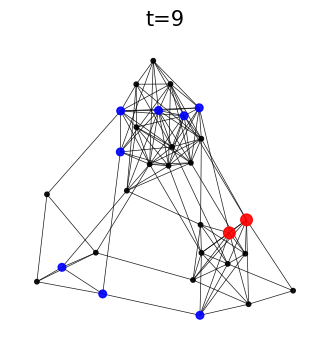

In [50]:
animate_observations_history(tao.env, agent=tao.agents[7], plot_dim=(4, 4), fps=1.5, pos_seed=30107,
                             spring_k=0.05, uninfected_node_size=30, unobserved_node_size=10)

Compute performance metric again

In [51]:
# performance metrics are computed for all agents by default
agents_auc_2 = tao.evaluate_performance(as_dataframe=True)

In [52]:
# let's have a look at the results
agents_auc_2.head(10)

,agent_id,passive_policy,passive_num_batch,active_policy,active_num_batch,active_start_time,query_time,time,num_unobserved_nodes,performance
0,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,0,29,0.857143
1,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,1,28,0.596154
2,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,2,27,0.200000
3,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,3,26,0.458333
4,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,4,25,0.484848
5,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,5,24,0.412500
6,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,6,23,0.973684
7,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,7,22,0.875000
8,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,8,21,0.826923
9,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,9,20,0.606061


Let's plot the performance metrics by active allocation-policy (we should probably not read into these results too much given the size of the graph and the small number of agent replicates per allocation-policy)

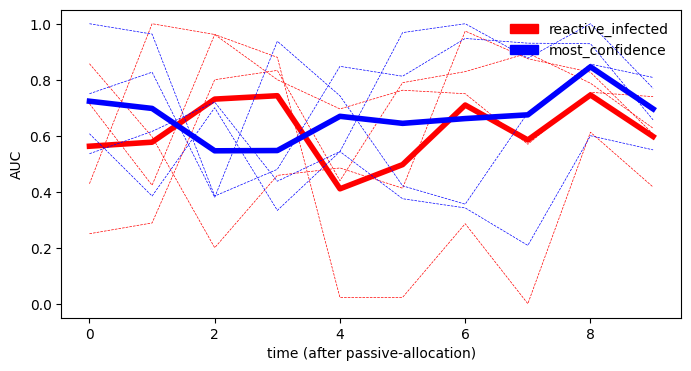

In [53]:
# set up figure
fig, ax = plt.subplots(figsize=(8, 4))

# plot AUC for agents with reactive_infected as active-policy
for agent in agents_auc_2[agents_auc_2.active_policy == 'reactive_infected'].agent_id.unique():
    df = agents_auc_2[agents_auc_2.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='r')
# compute average AUC per time
reactive_infected_avg_auc = agents_auc_2[agents_auc_2.active_policy == 'reactive_infected'].groupby('time').performance.mean()
# plot average AUC
ax.plot(reactive_infected_avg_auc.index, reactive_infected_avg_auc, linestyle='-', linewidth=4, color='r')

# plot AUC for agents with least_confidence as active-policy
for agent in agents_auc_2[agents_auc_2.active_policy == 'most_confidence'].agent_id.unique():
    df = agents_auc_2[agents_auc_2.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='b')
# compute average AUC per time
least_conf_avg_auc = agents_auc_2[agents_auc_2.active_policy == 'most_confidence'].groupby('time').performance.mean()
# plot average AUC
ax.plot(least_conf_avg_auc.index, least_conf_avg_auc, linestyle='-', linewidth=4, color='b')

# add axis labels
ax.set_xlabel('time (after passive-allocation)')
ax.set_ylabel('AUC')

# add legend (adjust custom colours)
red_patch = mpatches.Patch(color='red', label='reactive_infected')
blue_patch = mpatches.Patch(color='blue', label='most_confidence')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', frameon=False)

plt.show()

#### (13) How to add your own evaluation metric?
What if we are only interested in finding infected nodes? Let's implement a custom metric that calculates the proportion of (true) infected nodes that we have observed

In [54]:
def infected_detection(**kwargs):
    """
    Selects n unobserved nodes with least uncertain infection_estimates, i.e. estimate of latent probability p of infection states closest to 0 or 1.
    Available kwargs:
        - env_graph: graph of environment (a networkx undirected graph object)
        - infection_states_history: history of infection states (dict)
        - observed_infection_states_history: history of observed infection states (as observed by the agent) (dict)
        - infection_estimates_history: history of posterior samples of probability of infection of all nodes (numpyro mcmc object)
    """
    # get env_graph, surrogate and num_batch (not needed in this case)
    # env_graph = kwargs['env_graph'] # not used in this example
    infection_states_history = kwargs['infection_states_history']
    observed_infection_states_history = kwargs['observed_infection_states_history']
    # infection_estimates_history = kwargs['infection_estimates_history'] # not used in this example

    # iterate over time-steps in observed_infection_states_history
    score_history = {}
    for time, observed_infection_states in observed_infection_states_history.items():
        # get observed nodes
        observed_nodes = np.where(np.array(observed_infection_states) != -1)[0]
        # get infected nodes from infection_states_history
        infected_nodes = np.where(np.array(infection_states_history[time]) == 1)[0]
        # count how many of these infected nodes are observed
        infected_observed_num = len(set(observed_nodes).intersection(set(infected_nodes)))
        # normalise by number of infected nodes and store
        score_history[time] = infected_observed_num / len(infected_nodes)

    return score_history

Let's add it to the evaluator object

In [55]:
# add custom metric
evaluator.add_custom_metric('infected_detection', infected_detection)

# note that, by default, the metric is set to the newly added custom metric
evaluator.__dict__

{'metric': 'infected_detection',
 'custom_metrics': {'infected_detection': <function __main__.infected_detection(**kwargs)>}}

Now add it to the TaoManager and compute the new evalution metric

In [56]:
# add evaluator to TaoManager
tao.evaluator = evaluator
# performance metrics are computed for all agents by default
agents_auc_custom = tao.evaluate_performance(as_dataframe=True)

In [57]:
# let's have a look at the results
agents_auc_custom.head(10)

,agent_id,passive_policy,passive_num_batch,active_policy,active_num_batch,active_start_time,query_time,time,num_unobserved_nodes,performance
0,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,0,29,0.500000
1,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,1,28,0.333333
2,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,2,27,0.333333
3,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,3,26,0.333333
4,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,4,25,0.250000
5,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,5,24,0.333333
6,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,6,23,0.333333
7,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,7,22,0.333333
8,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,8,21,0.200000
9,18f5bbe2-eb0f-42,index_node,1,reactive_infected,1,0,1,9,20,0.250000


Let's plot the new performance metrics by active allocation-policy (we should probably not read into these results too much given the size of the graph and the small number of agent replicates per allocation-policy)

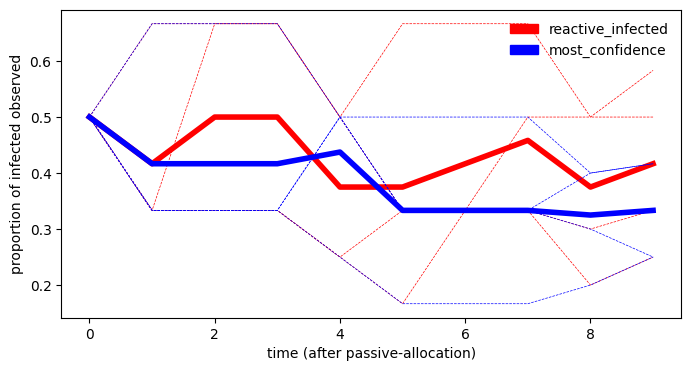

In [59]:
# set up figure
fig, ax = plt.subplots(figsize=(8, 4))

# plot AUC for agents with reactive_infected as active-policy
for agent in agents_auc_custom[agents_auc_custom.active_policy == 'reactive_infected'].agent_id.unique():
    df = agents_auc_custom[agents_auc_custom.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='r')
# compute average AUC per time
reactive_infected_avg_auc = agents_auc_custom[agents_auc_custom.active_policy == 'reactive_infected'].groupby('time').performance.mean()
# plot average AUC
ax.plot(reactive_infected_avg_auc.index, reactive_infected_avg_auc, linestyle='-', linewidth=4, color='r')

# plot AUC for agents with least_confidence as active-policy
for agent in agents_auc_custom[agents_auc_custom.active_policy == 'most_confidence'].agent_id.unique():
    df = agents_auc_custom[agents_auc_custom.agent_id == agent]
    xs = df.time
    ys = df.performance
    ax.plot(xs, ys, linestyle='--', linewidth=0.5, color='b')
# compute average AUC per time
least_conf_avg_auc = agents_auc_custom[agents_auc_custom.active_policy == 'most_confidence'].groupby('time').performance.mean()
# plot average AUC
ax.plot(least_conf_avg_auc.index, least_conf_avg_auc, linestyle='-', linewidth=4, color='b')

# add axis labels
ax.set_xlabel('time (after passive-allocation)')
ax.set_ylabel('proportion of infected observed')

# add legend (adjust custom colours)
red_patch = mpatches.Patch(color='red', label='reactive_infected')
blue_patch = mpatches.Patch(color='blue', label='most_confidence')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', frameon=False)

plt.show()